In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [14]:
df = pd.read_excel('merged17-20.xlsx')
df.head()

,Неделя,Всього захворіло,у т.ч.діти до 17 років,18 - 29,30 - 64,65 та старші,Госпіталізація,Показник захворюваності,Епідпоріг,Перевищення епідпорогу (%)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,41.0,7891.0,5836.0,639.0,1147.0,269.0,142.0,291.94,527.44,-44.65
2,42.0,6736.0,4928.0,517.0,1029.0,262.0,160.0,249.21,541.73,-54.00
3,43.0,6835.0,4392.0,796.0,1307.0,340.0,147.0,252.87,634.05,-60.12
4,44.0,7595.0,4965.0,870.0,1377.0,383.0,160.0,280.99,568.92,-50.61


In [15]:
df = df.iloc[1:]
df = df.iloc[:32, :]
dic = list(df.columns)
col_dict = dict(zip(dic, ['week', 'total','upto17', '18-29', '30-64', '65+', 'hospital', 'indicator', 'epid', 'epid excess']))
df2 = df.rename(columns = col_dict, inplace = False)
df2[['week', 'total', 'upto17', '18-29', '30-64', '65+', 'hospital']] \
= df2[['week', 'total', 'upto17', '18-29', '30-64', '65+', 'hospital']].astype(int)
df2.tail()

,week,total,upto17,18-29,30-64,65+,hospital,indicator,epid,epid excess
28,16,5864,3775,524,1224,341,138,218.35,486.36,-55.10
29,17,5932,4019,451,1161,301,132,220.89,418.65,-47.24
30,18,3975,2658,322,783,212,142,148.01,340.46,-56.53
31,19,3970,2645,312,816,197,118,147.83,384.56,-61.56
32,20,3990,2649,326,795,220,69,148.57,459.97,-67.70


In [16]:
df2.head()

,week,total,upto17,18-29,30-64,65+,hospital,indicator,epid,epid excess
1,41,7891,5836,639,1147,269,142,291.94,527.44,-44.65
2,42,6736,4928,517,1029,262,160,249.21,541.73,-54.00
3,43,6835,4392,796,1307,340,147,252.87,634.05,-60.12
4,44,7595,4965,870,1377,383,160,280.99,568.92,-50.61
5,45,8209,5511,894,1448,356,168,303.70,572.42,-46.94


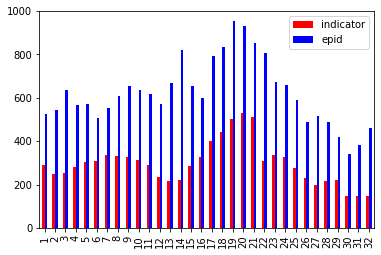

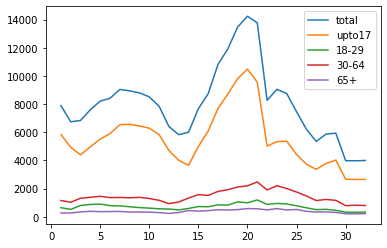

In [17]:
df2.iloc[:, 7:9].plot(kind='bar', color=['red', 'blue'])
df3 = df2.iloc[:, 1:6]
df3.plot()

<Figure size 432x288 with 0 Axes>

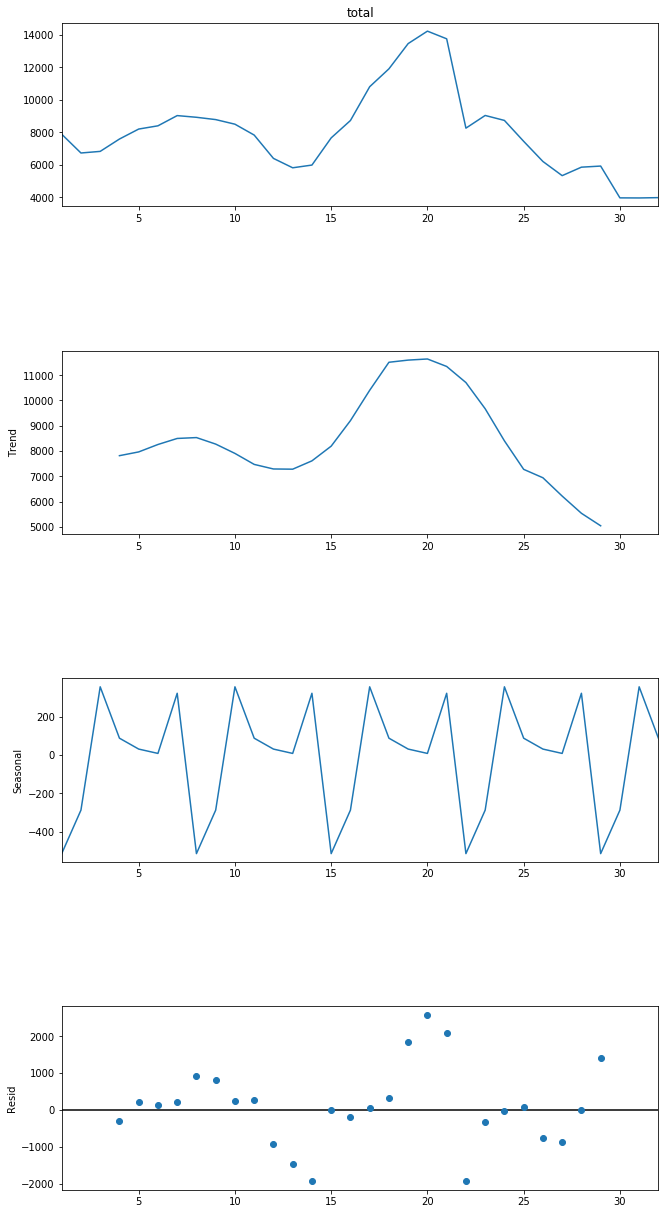

In [18]:
decomposition = seasonal_decompose(df2.total, period=7)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 20)

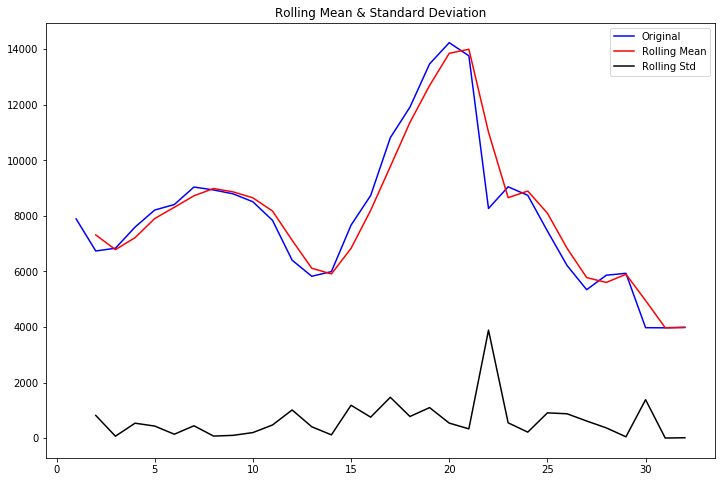

Results of Dickey-Fuller Test:
Test Statistic                 -1.043558
p-value                         0.737048
#Lags Used                      0.000000
Number of Observations Used    31.000000
Critical Value (1%)            -3.661429
Critical Value (5%)            -2.960525
Critical Value (10%)           -2.619319
dtype: float64


In [19]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=2).mean()
    rolstd = pd.Series(timeseries).rolling(window=2).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.total)

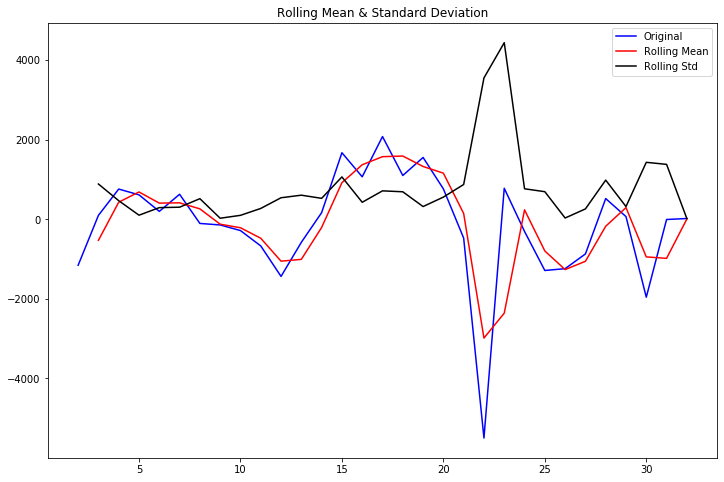

Results of Dickey-Fuller Test:
Test Statistic                 -4.321962
p-value                         0.000407
#Lags Used                      0.000000
Number of Observations Used    30.000000
Critical Value (1%)            -3.669920
Critical Value (5%)            -2.964071
Critical Value (10%)           -2.621171
dtype: float64


In [20]:
#  first difference
df2['first_diff'] = df2.total - df2.total.shift(1)
test_stationarity(df2.first_diff.dropna(inplace=False))

In [21]:
# brute force calculating parameters for SARIMA
import itertools
p = range(0,3)
q = range(0,3)
d = range(0,2)
s = (4, 12, 32) # means season duration (попробовал взять месяц, время года и весь эпидсезон) -> тот же результат


pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(df2.first_diff,
                          order=param,
                          seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 20, method = 'powell')
        except:
            continue
print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
pdq, seasonal_pdq, aic = param, param_seasonal, results.aic
print(pdq, seasonal_pdq, aic)

Optimization terminated successfully.
         Current function value: 8.364670
         Iterations: 1
         Function evaluations: 12
Optimization terminated successfully.
         Current function value: 8.364670
         Iterations: 1
         Function evaluations: 12
Optimization terminated successfully.
         Current function value: 8.364670
         Iterations: 1
         Function evaluations: 12
Optimization terminated successfully.
         Current function value: 8.364145
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 8.363431
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 8.364670
         Iterations: 1
         Function evaluations: 24


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


Optimization terminated successfully.
         Current function value: 8.362849
         Iterations: 2
         Function evaluations: 79
Optimization terminated successfully.
         Current function value: 8.342450
         Iterations: 3
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 8.364670
         Iterations: 2
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 7.875962
         Iterations: 2
         Function evaluations: 38
Optimization terminated successfully.
         Current function value: 5.587142
         Iterations: 2
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 13
Optimization terminated successfully.
         Current function value: 7.625976
         Iterations: 3
         Function evaluations: 81


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:1223: RuntimeWarning: invalid value encountered in true_divide
  (self.nobs - self.ssm.loglikelihood_burn)


Optimization terminated successfully.
         Current function value: 5.504142
         Iterations: 3
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 25


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/numpy/linalg/linalg.py:1872: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


Optimization terminated successfully.
         Current function value: 7.775284
         Iterations: 2
         Function evaluations: 236
Optimization terminated successfully.
         Current function value: 5.463406
         Iterations: 4
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: 8.364091
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 8.363328
         Iterations: 2
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 8.364670
         Iterations: 1
         Function evaluations: 25
Optimization terminated successfully.
         Current function value: 8.364344
         Iterations: 2
         Function evaluations: 70
Optimization terminated successfully.


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.624575
         Iterations: 3
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 5.460008
         Iterations: 4
         Function evaluations: 158
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: 7.625089
         Iterations: 3
         Function evaluations: 221
Optimization terminated successfully.
         Current function value: 5.437308
         Iterations: 8
         Function evaluations: 420
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: 8.362772
         Iterations: 2
         Function evaluations: 65
Optimization terminated successfull

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 5.421926
         Iterations: 5
         Function evaluations: 242
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: 7.619563
         Iterations: 4
         Function evaluations: 277
Optimization terminated successfully.
         Current function value: 5.422305
         Iterations: 6
         Function evaluations: 376
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 8.343698
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 8.343698
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Optimization terminated successfully.
         Current function value: 7.582848
         Iterations: 3
         Function evaluations: 121
Optimization terminated successfully.
         Current function value: 5.488759
         Iterations: 4
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: 7.579721
         Iterations: 3
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 5.451112
         Iterations: 5
         Function evaluations: 255
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: 8.341898
         Iterations: 2
         Function evaluations: 66
Optimization terminated successfull

Optimization terminated successfully.
         Current function value: 8.341096
         Iterations: 2
         Function evaluations: 86
Optimization terminated successfully.
         Current function value: 8.342248
         Iterations: 2
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 8.342225
         Iterations: 2
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 8.341088
         Iterations: 2
         Function evaluations: 108
Optimization terminated successfully.
         Current function value: 8.342248
         Iterations: 2
         Function evaluations: 129
Optimization terminated successfully.
         Current function value: 8.330857
         Iterations: 3
         Function evaluations: 197
Optimization terminated successfully.
         Current function value: 8.317300
         Iterations: 4
         Function evaluations: 282
Optimization terminated successfully

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:902: RuntimeWarning: Mean of empty slice.
  params_variance = (residuals[k_params_ma:] ** 2).mean()
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 5.354918
         Iterations: 2
         Function evaluations: 81
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 37
Optimization terminated successfully.
         Current function value: 8.584397
         Iterations: 2
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 8.592588
         Iterations: 2
         Function evaluations: 43
Optimization terminated successfully.
         Current function value: 8.593215
         Iterations: 1
         Function evaluations: 34
Optimization terminated successfully.
         Current function value: 8.552950
         Iterations: 3
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 8.592584
         Iterations: 1
         Function evaluations: 33
Optimization terminated successfully.
 

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.483521
         Iterations: 4
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 5.361252
         Iterations: 5
         Function evaluations: 198
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 37


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 5.349285
         Iterations: 6
         Function evaluations: 300
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: 8.546892
         Iterations: 2
         Function evaluations: 70
Optimization terminated successfully.
         Current function value: 8.530269
         Iterations: 6
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: 8.593215
         Iterations: 1
         Function evaluations: 57
Optimization terminated successfully.
         Current function value: 8.547545
         Iterations: 2
         Function evaluations: 91
Optimization terminated successfully.
         Current function value: 8.530266
         Iterations: 4
         Function evaluations: 184
Optimization terminated successfully.

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.480175
         Iterations: 4
         Function evaluations: 199
Optimization terminated successfully.
         Current function value: 5.300610
         Iterations: 11
         Function evaluations: 647
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 5.301149
         Iterations: 7
         Function evaluations: 433
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 8.420797
         Iterations: 2
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: 8.420797
         Iterations: 2
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: 8.420797
         Iterations: 2
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: 8.419748
         Iterations: 2
         Function evaluations: 72
Optimization terminated successfully.
         Current function value: 8.415573
         Iterations: 2
         Function evaluations: 72
Optimization terminated successfully.
 

Optimization terminated successfully.
         Current function value: 8.392361
         Iterations: 3
         Function evaluations: 144
Optimization terminated successfully.
         Current function value: 8.395866
         Iterations: 3
         Function evaluations: 148
Optimization terminated successfully.
         Current function value: 8.381478
         Iterations: 3
         Function evaluations: 171
Optimization terminated successfully.
         Current function value: 8.365628
         Iterations: 4
         Function evaluations: 305
Optimization terminated successfully.
         Current function value: 8.395822
         Iterations: 3
         Function evaluations: 186
Optimization terminated successfully.
         Current function value: 7.599048
         Iterations: 3
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 5.305068
         Iterations: 2
         Function evaluations: 161
Optimization terminated successful

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.579057
         Iterations: 3
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 5.488419
         Iterations: 4
         Function evaluations: 167


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.576609
         Iterations: 3
         Function evaluations: 149
Optimization terminated successfully.
         Current function value: 5.452962
         Iterations: 4
         Function evaluations: 201


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 8.340004
         Iterations: 1
         Function evaluations: 32
Optimization terminated successfully.
         Current function value: 8.340993
         Iterations: 2
         Function evaluations: 66
Optimization terminated successfully.
         Current function value: 8.342238
         Iterations: 1
         Function evaluations: 35
Optimization terminated successfully.
         Current function value: 8.342195
         Iterations: 2
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 8.340977
         Iterations: 2
         Function evaluations: 96
Optimization terminated successfully.
         Current function value: 8.342238
         Iterations: 1
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: 8.330089
         Iterations: 2
         Function evaluations: 113
Optimization terminated successfully.
 

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 5.449691
         Iterations: 4
         Function evaluations: 200


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.576333
         Iterations: 3
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: 5.442833
         Iterations: 5
         Function evaluations: 312


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 8.329804
         Iterations: 2
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 8.295082
         Iterations: 4
         Function evaluations: 188
Optimization terminated successfully.
         Current function value: 8.342238
         Iterations: 1
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 8.336011
         Iterations: 2
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: 8.295082
         Iterations: 4
         Function evaluations: 232
Optimization terminated successfully.
         Current function value: 8.342238
         Iterations: 1
         Function evaluations: 78
Optimization terminated successfully.
         Current function value: 8.329704
         Iterations: 3
         Function evaluations: 206
Optimization terminated successfully.

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.576508
         Iterations: 8
         Function evaluations: 480
Optimization terminated successfully.
         Current function value: 5.416505
         Iterations: 5
         Function evaluations: 302


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.576208
         Iterations: 5
         Function evaluations: 371
Optimization terminated successfully.
         Current function value: 5.415728
         Iterations: 6
         Function evaluations: 443


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 8.342279
         Iterations: 2
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 8.342279
         Iterations: 2
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 8.342279
         Iterations: 2
         Function evaluations: 69
Optimization terminated successfully.
         Current function value: 8.340363
         Iterations: 2
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: 8.341260
         Iterations: 2
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 8.342279
         Iterations: 2
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 8.330118
         Iterations: 3
         Function evaluations: 175
Optimization terminated successfully.
  

Optimization terminated successfully.
         Current function value: 8.314808
         Iterations: 3
         Function evaluations: 212
Optimization terminated successfully.
         Current function value: 8.339313
         Iterations: 2
         Function evaluations: 137
Optimization terminated successfully.
         Current function value: 7.783943
         Iterations: 4
         Function evaluations: 191
Optimization terminated successfully.
         Current function value: 5.556726
         Iterations: 2
         Function evaluations: 90
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Optimization terminated successfully.
         Current function value: 7.578511
         Iterations: 4
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: 5.488778
         Iterations: 4
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 7.576251
         Iterations: 5
         Function evaluations: 360
Optimization terminated successfully.
         Current function value: 5.452091
         Iterations: 5
         Function evaluations: 355
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 73
Optimization terminated successfully.
         Current function value: 8.339243
         Iterations: 2
         Function evaluations: 111
Optimization terminated successful

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.431774
         Iterations: 3
         Function evaluations: 118
Optimization terminated successfully.
         Current function value: 5.327934
         Iterations: 4
         Function evaluations: 165
Optimization terminated successfully.
         Current function value: 7.430475
         Iterations: 3
         Function evaluations: 146


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 5.303342
         Iterations: 4
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: 8.499287
         Iterations: 2
         Function evaluations: 69


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 8.509234
         Iterations: 2
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: 8.509235
         Iterations: 1
         Function evaluations: 36
Optimization terminated successfully.
         Current function value: 8.490692
         Iterations: 2
         Function evaluations: 101
Optimization terminated successfully.
         Current function value: 8.509234
         Iterations: 1
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: 8.509234
         Iterations: 1
         Function evaluations: 53
Optimization terminated successfully.
         Current function value: 8.479865
         Iterations: 2
         Function evaluations: 113
Optimization terminated successfully.
         Current function value: 8.479072
         Iterations: 3
         Function evaluations: 183
Optimization terminated successfully.


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.430136
         Iterations: 4
         Function evaluations: 201
Optimization terminated successfully.
         Current function value: 5.306642
         Iterations: 6
         Function evaluations: 303


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.429206
         Iterations: 3
         Function evaluations: 183
Optimization terminated successfully.
         Current function value: 5.294475
         Iterations: 8
         Function evaluations: 518


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 8.479982
         Iterations: 2
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: 8.452607
         Iterations: 3
         Function evaluations: 145
Optimization terminated successfully.
         Current function value: 8.509235
         Iterations: 1
         Function evaluations: 64
Optimization terminated successfully.
         Current function value: 8.480338
         Iterations: 2
         Function evaluations: 115
Optimization terminated successfully.
         Current function value: 8.452607
         Iterations: 3
         Function evaluations: 174
Optimization terminated successfully.
         Current function value: 8.509234
         Iterations: 1
         Function evaluations: 82
Optimization terminated successfully.
         Current function value: 8.479972
         Iterations: 2
         Function evaluations: 137
Optimization terminated successfully.

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.428744
         Iterations: 4
         Function evaluations: 245
Optimization terminated successfully.
         Current function value: 5.257375
         Iterations: 8
         Function evaluations: 519


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.430043
         Iterations: 4
         Function evaluations: 293
Optimization terminated successfully.
         Current function value: 5.257853
         Iterations: 8
         Function evaluations: 613


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 8.393346
         Iterations: 3
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 8.393346
         Iterations: 3
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 8.393346
         Iterations: 3
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 8.389785
         Iterations: 3
         Function evaluations: 147
Optimization terminated successfully.
         Current function value: 8.390127
         Iterations: 3
         Function evaluations: 151
Optimization terminated successfully.
         Current function value: 8.392967
         Iterations: 3
         Function evaluations: 154
Optimization terminated successfully.
         Current function value: 8.374622
         Iterations: 3
         Function evaluations: 185
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 8.385657
         Iterations: 4
         Function evaluations: 283
Optimization terminated successfully.
         Current function value: 8.358763
         Iterations: 8
         Function evaluations: 613
Optimization terminated successfully.
         Current function value: 8.401278
         Iterations: 3
         Function evaluations: 228
Optimization terminated successfully.
         Current function value: 7.546544
         Iterations: 3
         Function evaluations: 156
Optimization terminated successfully.
         Current function value: 5.291120
         Iterations: 2
         Function evaluations: 92
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 49
Optimization terminated successfully.
         Current function value: 7.370077
         Iterations: 10
         Function evaluations: 670
Optimization terminated successful

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 5.488353
         Iterations: 4
         Function evaluations: 208


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.576548
         Iterations: 3
         Function evaluations: 176
Optimization terminated successfully.
         Current function value: 5.452308
         Iterations: 4
         Function evaluations: 242
Optimization terminated successfully.
         Current function value: 8.339780
         Iterations: 2
         Function evaluations: 88


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 8.340978
         Iterations: 2
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 8.342177
         Iterations: 1
         Function evaluations: 47
Optimization terminated successfully.
         Current function value: 8.342122
         Iterations: 2
         Function evaluations: 125
Optimization terminated successfully.
         Current function value: 8.340968
         Iterations: 2
         Function evaluations: 112
Optimization terminated successfully.
         Current function value: 8.342177
         Iterations: 1
         Function evaluations: 63
Optimization terminated successfully.
         Current function value: 8.329872
         Iterations: 2
         Function evaluations: 132
Optimization terminated successfully.
         Current function value: 8.316160
         Iterations: 4
         Function evaluations: 285
Optimization terminated successfully.

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.576140
         Iterations: 4
         Function evaluations: 243
Optimization terminated successfully.
         Current function value: 5.449219
         Iterations: 4
         Function evaluations: 242


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.575721
         Iterations: 4
         Function evaluations: 294
Optimization terminated successfully.
         Current function value: 5.430368
         Iterations: 7
         Function evaluations: 526


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 8.329623
         Iterations: 2
         Function evaluations: 110
Optimization terminated successfully.
         Current function value: 8.294826
         Iterations: 4
         Function evaluations: 231
Optimization terminated successfully.
         Current function value: 8.342177
         Iterations: 1
         Function evaluations: 68
Optimization terminated successfully.
         Current function value: 8.335789
         Iterations: 2
         Function evaluations: 138
Optimization terminated successfully.
         Current function value: 8.294826
         Iterations: 4
         Function evaluations: 272
Optimization terminated successfully.
         Current function value: 8.342177
         Iterations: 1
         Function evaluations: 83
Optimization terminated successfully.
         Current function value: 8.329534
         Iterations: 3
         Function evaluations: 238
Optimization terminated successfully

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.576184
         Iterations: 8
         Function evaluations: 574
Optimization terminated successfully.
         Current function value: 5.415011
         Iterations: 5
         Function evaluations: 354


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.576091
         Iterations: 5
         Function evaluations: 427
Optimization terminated successfully.
         Current function value: 5.414242
         Iterations: 6
         Function evaluations: 511


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 8.342230
         Iterations: 2
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 8.342230
         Iterations: 2
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 8.342230
         Iterations: 2
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 8.340470
         Iterations: 2
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 8.341114
         Iterations: 2
         Function evaluations: 119
Optimization terminated successfully.
         Current function value: 8.342230
         Iterations: 2
         Function evaluations: 120
Optimization terminated successfully.
         Current function value: 8.330271
         Iterations: 3
         Function evaluations: 211
Optimization terminated successfully.

Optimization terminated successfully.
         Current function value: 8.316370
         Iterations: 4
         Function evaluations: 323
Optimization terminated successfully.
         Current function value: 8.342176
         Iterations: 2
         Function evaluations: 170
Optimization terminated successfully.
         Current function value: 7.755757
         Iterations: 4
         Function evaluations: 252
Optimization terminated successfully.
         Current function value: 5.547500
         Iterations: 4
         Function evaluations: 239
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 7.577656
         Iterations: 3
         Function evaluations: 222
Optimization terminated successfully.
         Current function value: 5.484547
         Iterations: 5
         Function evaluations: 362
Optimization terminated successful

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 5.280322
         Iterations: 4
         Function evaluations: 215


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.394575
         Iterations: 4
         Function evaluations: 244
Optimization terminated successfully.
         Current function value: 5.263350
         Iterations: 4
         Function evaluations: 245


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 8.461180
         Iterations: 2
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: 8.465046
         Iterations: 2
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: 8.469019
         Iterations: 1
         Function evaluations: 48
Optimization terminated successfully.
         Current function value: 8.453520
         Iterations: 2
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: 8.465011
         Iterations: 2
         Function evaluations: 114
Optimization terminated successfully.
         Current function value: 8.469019
         Iterations: 1
         Function evaluations: 67
Optimization terminated successfully.
         Current function value: 8.445216
         Iterations: 3
         Function evaluations: 202
Optimization terminated successfully.


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.394510
         Iterations: 4
         Function evaluations: 249
Optimization terminated successfully.
         Current function value: 5.271027
         Iterations: 6
         Function evaluations: 374


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.394611
         Iterations: 4
         Function evaluations: 301
Optimization terminated successfully.
         Current function value: 5.262738
         Iterations: 8
         Function evaluations: 592


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 8.445144
         Iterations: 2
         Function evaluations: 117
Optimization terminated successfully.
         Current function value: 8.394803
         Iterations: 4
         Function evaluations: 240
Optimization terminated successfully.
         Current function value: 8.469019
         Iterations: 1
         Function evaluations: 75
Optimization terminated successfully.
         Current function value: 8.444087
         Iterations: 3
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: 8.394834
         Iterations: 4
         Function evaluations: 289
Optimization terminated successfully.
         Current function value: 8.469019
         Iterations: 1
         Function evaluations: 94
Optimization terminated successfully.
         Current function value: 8.445058
         Iterations: 2
         Function evaluations: 162
Optimization terminated successfully

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.396388
         Iterations: 5
         Function evaluations: 361
Optimization terminated successfully.
         Current function value: 5.219714
         Iterations: 8
         Function evaluations: 589


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 7.393034
         Iterations: 6
         Function evaluations: 519
Optimization terminated successfully.
         Current function value: 5.219956
         Iterations: 7
         Function evaluations: 627


/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 8.392716
         Iterations: 3
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 8.392716
         Iterations: 3
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 8.392716
         Iterations: 3
         Function evaluations: 150
Optimization terminated successfully.
         Current function value: 8.388670
         Iterations: 3
         Function evaluations: 185
Optimization terminated successfully.
         Current function value: 8.389874
         Iterations: 3
         Function evaluations: 187
Optimization terminated successfully.
         Current function value: 8.392294
         Iterations: 3
         Function evaluations: 189
Optimization terminated successfully.
         Current function value: 8.373260
         Iterations: 3
         Function evaluations: 224
Optimization terminated successful

Optimization terminated successfully.
         Current function value: 8.374087
         Iterations: 4
         Function evaluations: 325
Optimization terminated successfully.
         Current function value: 8.360151
         Iterations: 5
         Function evaluations: 401
Optimization terminated successfully.
         Current function value: 8.391789
         Iterations: 4
         Function evaluations: 339
Optimization terminated successfully.
         Current function value: 7.540712
         Iterations: 3
         Function evaluations: 184
Optimization terminated successfully.
         Current function value: 5.276709
         Iterations: 2
         Function evaluations: 124
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 61
Optimization terminated successfully.
         Current function value: 7.369016
         Iterations: 8
         Function evaluations: 586
Optimization terminated successful

In [29]:
mod = SARIMAX(df2.total, trend='n', order=pdq, seasonal_order=seasonal_pdq)
results = mod.fit()
print(results.summary())

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


                                     SARIMAX Results                                      
Dep. Variable:                              total   No. Observations:                   32
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 32)   Log Likelihood                   0.000
Date:                            Fri, 05 Nov 2021   AIC                             18.000
Time:                                    23:55:55   BIC                                nan
Sample:                                         0   HQIC                               nan
                                             - 32                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1              -0         -0        nan        nan           0          -0
ar.L2               0         -0   

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/eval_measures.py:406: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/eval_measures.py:431: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2939: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/mlemodel.py:2939: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:468: RuntimeWarning: Mean of empty slice.
  xo = x - x.mean()
/Users/arima/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:1

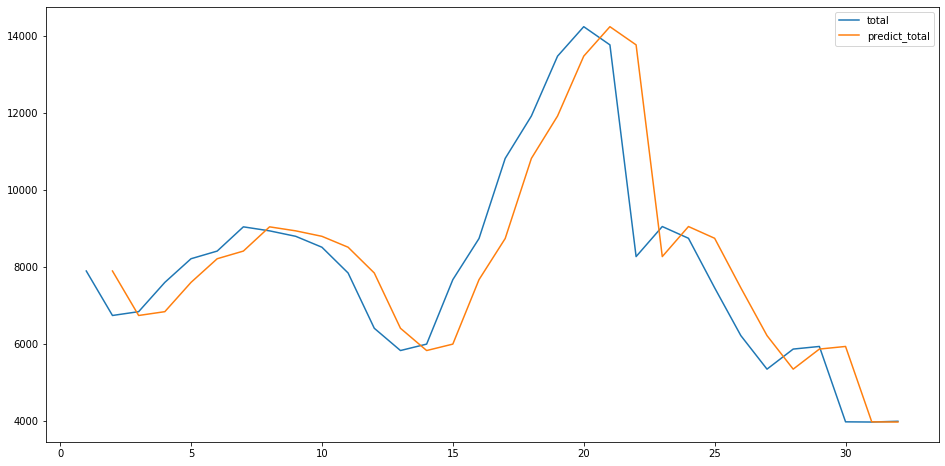

In [30]:
df2['predict_total'] = results.predict(start=1, end=32, dynamic=False)  
df2[['total', 'predict_total']].plot(figsize=(16, 8))

In [31]:
pdq, seasonal_pdq = (2, 1, 2), (2, 1, 2, 4)
mod = SARIMAX(df2.total, trend='n', order=pdq, seasonal_order=seasonal_pdq)
results = mod.fit()
print(results.summary())

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                     
Dep. Variable:                             total   No. Observations:                   32
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 4)   Log Likelihood                -239.054
Date:                           Fri, 05 Nov 2021   AIC                            496.108
Time:                                   23:56:48   BIC                            507.771
Sample:                                        0   HQIC                           499.576
                                            - 32                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4027      5.306     -0.076      0.939     -10.802       9.996
ar.L2          0.2799      3.248      0.086

/Users/arima/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


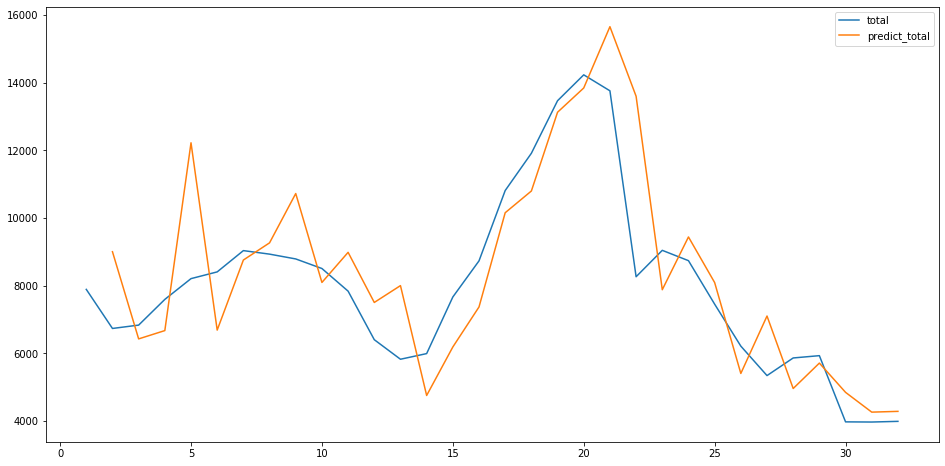

In [32]:
df2['predict_total'] = results.predict(start=1, end=32, dynamic=False)  
df2[['total', 'predict_total']].plot(figsize=(16, 8))